# **COMP9517 - Group Project (Segmentation Models Pytorch)**

## **0. Add Imports**

In [1]:
# !conda env create -f environment.yaml

In [ ]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))

import matplotlib.pyplot as plt
import numpy as np

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping, RichModelSummary, Timer
from lightning.pytorch.loggers import TensorBoardLogger, WandbLogger

from data import AerialDeadTreeSegDataModule, download_dataset
from lightning.pytorch.tuner import Tuner
from lightning_modules import SMPLitModule
from models import FreezeSMPEncoderUtils
from utils import paths, callbacks
import segmentation_models_pytorch as smp


In [3]:
ARCH = "Unet"
ENCODER_NAME = "efficientnet-b5"
MODALITY = "merged"
TARGET_SIZE = 384
VERSION = f"{MODALITY}_{TARGET_SIZE}"
BATCH_SIZE = 16
ACCUMULATE_GRAD_BATCHES = 2
MAX_EPOCHS = 100
EARLY_STOPPING_PATIENCE = 20
LOSS1 = smp.losses.JaccardLoss(mode='binary', from_logits=True)
LOSS2 = smp.losses.FocalLoss(mode='binary')
MIN_LR = 1e-4
MAX_LR = 0.1  # Maximum learning rate for the learning rate finder
PRECISION = "bf16-mixed"

## **1. Simple Summary of the Dattaset**

In [4]:
from PIL import Image
# Get the data folder
data_folder = download_dataset()

rgb_dir = os.path.join(data_folder, "RGB_images")
nrg_dir = os.path.join(data_folder, "NRG_images")
mask_dir = os.path.join(data_folder, "masks")

# Get the max and min resolution of the images
def get_max_min_resolution(image_dir):
    max_res = (0, 0)
    min_res = (float('inf'), float('inf'))
    for filename in os.listdir(image_dir):
        if filename.endswith(".png"):
            filepath = os.path.join(image_dir, filename)
            with open(filepath, 'rb') as f:
                img = Image.open(f)
                height, width = img.size
                max_res = (max(max_res[0], height), max(max_res[1], width))
                min_res = (min(min_res[0], height), min(min_res[1], width))
    return max_res, min_res
max_rgb_res, min_rgb_res = get_max_min_resolution(rgb_dir)
max_nrg_res, min_nrg_res = get_max_min_resolution(nrg_dir)
print(f"Max RGB resolution: {max_rgb_res}, Min RGB resolution: {min_rgb_res}")
print(f"Max NRG resolution: {max_nrg_res}, Min NRG resolution: {min_nrg_res}")

Max RGB resolution: (652, 636), Min RGB resolution: (317, 294)
Max NRG resolution: (652, 636), Min NRG resolution: (317, 294)


## **2. Prepare Data Module**

In [5]:
data_module = AerialDeadTreeSegDataModule(
    val_split=0.1, test_split=0.2, seed=42,
    modality=MODALITY, # in_channels=4. If modality is "merged", it will use 4 channels (RGB + NIR); Otherwise, it will use 3 channels (RGB).
    batch_size=BATCH_SIZE,
    num_workers= int(os.cpu_count() / 2) if os.cpu_count() is not None else 0,
    target_size=TARGET_SIZE)

## **3. Create Segmentation Models**

In [6]:
model = SMPLitModule(
    arch=ARCH,
    encoder_name=ENCODER_NAME,
    encoder_weights="imagenet",
    in_channels=data_module.in_channels,
    out_classes=1,  # Binary segmentation
    loss1=LOSS1,
    loss2=LOSS2,
    target_size=TARGET_SIZE
)

## **4. Create Trainer**

In [ ]:
model_sum_callback = RichModelSummary(max_depth=2)

lr_monitor = LearningRateMonitor(logging_interval='step')

early_stop_callback = EarlyStopping(
    monitor="per_image_iou/val",
    patience=EARLY_STOPPING_PATIENCE,
    verbose=True,
    mode="max"  # Maximize the metric
)

timer = Timer(interval="epoch", verbose=False)
                
checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(paths.checkpoint_dir, f"smp_{ENCODER_NAME}_{ARCH}", VERSION),
    monitor="per_image_iou/val",
    filename="{epoch:02d}-{per_image_iou_val:.4f}",
    mode="max",
    save_top_k=2,
    enable_version_counter=True,
)

In [ ]:
logger = TensorBoardLogger(paths.tensorboard_log_dir, name=f"smp_{ENCODER_NAME}_{ARCH}", version=VERSION)
trainer = L.Trainer(
    precision=PRECISION,
    max_epochs=MAX_EPOCHS,
    enable_progress_bar=True,
    logger=logger,
    callbacks=[
        model_sum_callback,
        lr_monitor,
        early_stop_callback,
        timer,
        checkpoint_callback
    ],
    log_every_n_steps=5,
    accumulate_grad_batches=ACCUMULATE_GRAD_BATCHES,
)

Using bfloat16 Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## **5. Find Suggested Learning Rate**

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Using existing split: ./data_splits/data_split_42_70_10.csv

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.010964781961431854
Restoring states from the checkpoint path at /home/leo/unsw/comp9517/CV9517_Group-Project/notebooks/.lr_find_0166f4c0-0ac9-4880-a11e-02f2f4eedf5e.ckpt
Restored all states from the checkpoint at /home/leo/unsw/comp9517/CV9517_Group-Project/notebooks/.lr_find_0166f4c0-0ac9-4880-a11e-02f2f4eedf5e.ckpt


Teardown called, cleaning up datasets...

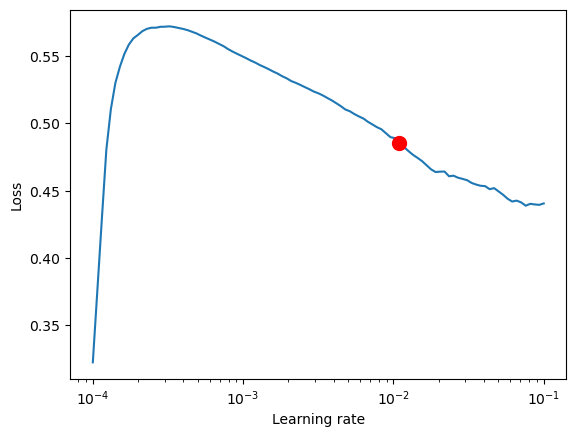

/tmp/ipykernel_124929/3363004638.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [9]:
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(model, datamodule=data_module,
                          min_lr=MIN_LR, max_lr=MAX_LR,
                          num_training=100, early_stop_threshold=4)
fig = lr_finder.plot(suggest=True, show=True)
fig.show()

## **6. Train and Test Segmentation Model**

In [10]:
trainer.fit(model, datamodule=data_module)
print("Training starting time: ", timer.start_time("train"))
print("Time elapsed: ", timer.time_elapsed("train"))

Using existing split: ./data_splits/data_split_42_70_10.csv

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃   ┃ Name                    ┃ Type                ┃ Params ┃ Mode  ┃            In sizes ┃            Out sizes ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0 │ model                   │ Unet                │ 31.2 M │ train │    [1, 4, 384, 384] │     [1, 1, 384, 384] │
│ 1 │ model.encoder           │ EfficientNetEncoder │ 28.3 M │ train │    [1, 4, 384, 384] │   [[1, 4, 384, 384], │
│   │                         │                     │        │       │                     │   [1, 48, 192, 192], │
│   │                         │                     │        │       │                     │ [1, 40, 96, 96], [1, │
│   │                         │                     │        │       │                     │     64, 48, 48], [1, │
│   │                         │                     │        │       │                     │    176, 24, 24], [1, │
│   │                         │                     │        │       │                     │        512, 12, 12]] │
│ 2 │ model.decoder           │ UnetDecoder         │  2.9 M │ train │  [[1, 4, 384, 384], │    [1, 16, 384, 384] │
│   │                         │                     │        │       │  [1, 48, 192, 192], │                      │
│   │                         │                     │        │       │    [1, 40, 96, 96], │                      │
│   │                         │                     │        │       │    [1, 64, 48, 48], │                      │
│   │                         │                     │        │       │   [1, 176, 24, 24], │                      │
│   │                         │                     │        │       │   [1, 512, 12, 12]] │                      │
│ 3 │ model.segmentation_head │ SegmentationHead    │    145 │ train │   [1, 16, 384, 384] │     [1, 1, 384, 384] │
│ 4 │ loss_fn1                │ JaccardLoss         │      0 │ train │                   ? │                    ? │
│ 5 │ loss_fn2                │ FocalLoss           │      0 │ train │                   ? │                    ? │
│ 6 │ _default_loss           │ DiceLoss            │      0 │ train │                   ? │                    ? │
└───┴─────────────────────────┴─────────────────────┴────────┴───────┴─────────────────────┴──────────────────────┘

Trainable params: 31.2 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 31.2 M                                                                                               
Total estimated model params size (MB): 124                                                                        
Modules in train mode: 670                                                                                         
Modules in eval mode: 0

Output()

Metric per_image_iou/val improved. New best score: 0.044


Metric per_image_iou/val improved by 0.120 >= min_delta = 0.001. New best score: 0.164


Metric per_image_iou/val improved by 0.054 >= min_delta = 0.001. New best score: 0.219


Metric per_image_iou/val improved by 0.107 >= min_delta = 0.001. New best score: 0.326


Metric per_image_iou/val improved by 0.031 >= min_delta = 0.001. New best score: 0.357


Metric per_image_iou/val improved by 0.042 >= min_delta = 0.001. New best score: 0.399


Metric per_image_iou/val improved by 0.002 >= min_delta = 0.001. New best score: 0.401


Metric per_image_iou/val improved by 0.018 >= min_delta = 0.001. New best score: 0.419


Metric per_image_iou/val improved by 0.002 >= min_delta = 0.001. New best score: 0.420


Metric per_image_iou/val improved by 0.009 >= min_delta = 0.001. New best score: 0.429


Metric per_image_iou/val improved by 0.012 >= min_delta = 0.001. New best score: 0.441


Metric per_image_iou/val improved by 0.007 >= min_delta = 0.001. New best score: 0.448


Metric per_image_iou/val improved by 0.008 >= min_delta = 0.001. New best score: 0.457


Metric per_image_iou/val improved by 0.005 >= min_delta = 0.001. New best score: 0.462


Metric per_image_iou/val improved by 0.002 >= min_delta = 0.001. New best score: 0.464


`Trainer.fit` stopped: `max_epochs=100` reached.


Teardown called, cleaning up datasets...

Training starting time:  15792.095966052
Time elapsed:  857.0750613149994


In [11]:
test_results = trainer.test(model, datamodule=data_module, ckpt_path="best")
print("Time elapsed: ", timer.time_elapsed("test"))

Using existing split: ./data_splits/data_split_42_70_10.csv

Restoring states from the checkpoint path at /home/leo/unsw/comp9517/CV9517_Group-Project/notebooks/checkpoints/Unet_efficientnet-b5_merged_384/merged_384/epoch=83-per_image_iou_val=0.4640.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/leo/unsw/comp9517/CV9517_Group-Project/notebooks/checkpoints/Unet_efficientnet-b5_merged_384/merged_384/epoch=83-per_image_iou_val=0.4640.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       accuracy/test       │    0.9849011301994324     │
│     dataset_iou/test      │    0.4971369206905365     │
│       f1_score/test       │    0.6313587427139282     │
│       f2_score/test       │    0.6533323526382446     │
│    per_image_iou/test     │    0.48180946707725525    │
│      precision/test       │    0.6290985345840454     │
│        recall/test        │    0.6782339215278625     │
│     sensitivity/test      │    0.6782339215278625     │
│     specificity/test      │     0.992051899433136     │
└───────────────────────────┴───────────────────────────┘

Teardown called, cleaning up datasets...

Time elapsed:  2.5615559389989357
